In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [23]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random
from pprint import pprint

from SVD import Metrics, SVDPredictor, LogisticSVD
from RecData import RecData

In [24]:
recs = pd.read_csv('data/recommendations.csv')

# Remove old ratings
recs = recs.sort_values(by=['date'], ascending=False)
recs.drop_duplicates(subset= ['app_id', 'user_id'], inplace=True) 

USED_COLS = ['app_id', 'is_recommended', 'user_id']
recs = recs[USED_COLS]

item_data = pd.read_csv('data/games.csv')
titles = item_data[['app_id', 'title']]

print("Shape:", recs.shape)
recs.head()

Shape: (14585287, 3)


,app_id,is_recommended,user_id
2307118,1145360,True,2597309
1889941,1846380,True,4457610
7378728,1000360,True,1152924
7939199,262060,False,6207094
11381505,1657630,False,6372672


In [3]:
random.seed(42)
np.random.seed(42)

rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

del recs

print("Creating splits...")
train_data, test = rec_data.train_test_split(test_size=0.2)
print("First split done.")
train_data, val = train_data.train_test_split(test_size=0.2)
print("Done creating splits.")

Creating utility matrix...
Done utility matrix.
Creating splits...
First split done.
Done creating splits.


In [4]:
rec_data._num_users

6903784

In [ ]:
# random.seed(42)
# np.random.seed(42)

# rec_data = RecData()
# rec_data.create_from_dataframe(recs)
# rec_data.set_titles(titles)

# del recs

# print("Creating splits...")
# train_data, val, test = rec_data.leave_k_out_split(k=1)
# print("Done creating splits.")

In [25]:
del item_data
del titles

In [26]:
EPOCHS = 20

random.seed(42)
np.random.seed(42)

# Fit and predict with svd
svd_predictor = LogisticSVD(
    train_data.get_num_users(), train_data.get_num_items(), 2, k=20, epochs=EPOCHS, 
    learning_rate=0.01, C=0.02)
svd_predictor.fit(train_data.get_matrix(), validation_set=val, early_stop=False)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

Epoch 0/Training error: 0.6931447856671623/Validation error: 0.693147172526505/Time: 336.87 seconds


KeyboardInterrupt: 

In [ ]:
# Ensure file exists
model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(
    *(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 
file = open(model_dir, 'a')
file.close()

# Save model
print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump([svd_predictor, rec_data, train_data, val, test], file)
print("Done saving model.")

Saving model...


In [ ]:
svd_predictor.continue_fit(1, early_stop=False)

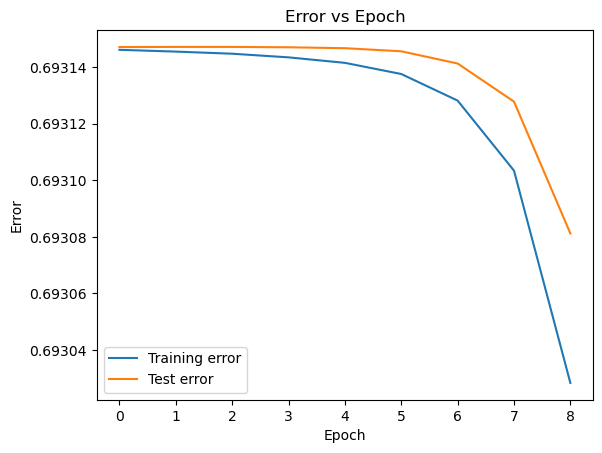

In [19]:
# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

In [18]:
j = 3
# Test top-n list for user j
top_n = svd_predictor.top_n(j, 20)
print("Predicted top n:")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

# User j true top n list
print("True top n:")
true_top = rec_data.top_n(j, 5000)
pprint([rec_data.index_to_title(index) for _, index in true_top])

Predicted top n:
[(0.5005029483151469, 'The WILDS'),
 (0.500502755671712, "Tony Stewart's All-American Racing"),
 (0.5004942558904721, 'Indiana Jones® and the Infernal Machine™'),
 (0.5004729374789738, 'Romans: Age of Caesar'),
 (0.5004542329999244, 'Grey Heritage: Faded Vision'),
 (0.5004066535448477, 'Pajama Sam 4: Life Is Rough When You Lose Your Stuff!'),
 (0.500367432085293, 'Nancy Drew®: The Haunting of Castle Malloy'),
 (0.5003442601204929, 'TramSim Vienna - The Tram Simulator'),
 (0.5003329502832796, 'Pure Rock Crawling'),
 (0.5003262577158485, 'Concordia: Digital Edition'),
 (0.5003255640691661, 'The Settlers® : Rise of an Empire - History Edition'),
 (0.5003098298133027, 'My Little Farmies'),
 (0.5003062666736864, '风信楼'),
 (0.5003016493177126, 'TRYP FPV : The Drone Racer Simulator'),
 (0.5002896553516163, 'Z1 Battle Royale'),
 (0.5002880153350073, 'The Settlers® : Heritage of Kings - History Edition'),
 (0.5002434109612911, 'CINERIS SOMNIA'),
 (0.5002425189488505,
  'Nelke & 

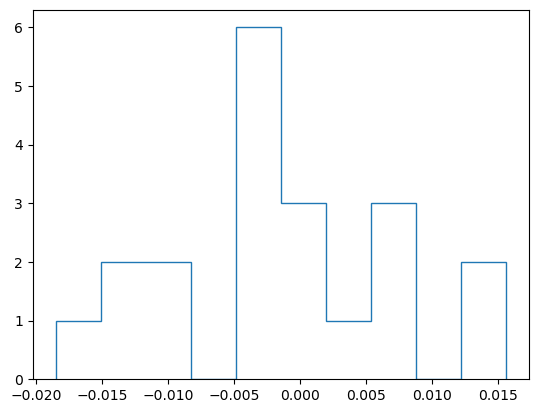

In [20]:
values, bins = np.histogram(svd_predictor._user_features[0, :])
plt.stairs(values, bins)
plt.show()

In [13]:
rec_data.search_title('mortal')

[('noel the mortal fate s1-7', 2161),
 ('mortal kombat x', 966),
 ('immortality', 856),
 ('mortal shell', 880),
 ('鬼谷八荒 tale of immortal', 1271),
 ('dark deception: monsters & mortals', 438),
 ('mortal online 2', 35),
 ('mortal kombat\xa011', 288)]

In [14]:
# prefs = [(606, 1), (1628, 1), (391, 0), (1330, 0), (500, 0), (709, 1), (840, 0), 
#          (58, 1), (456, 1), (153, 0), (158, 0), (1160, 0), (761, 0),
#                               (1771, 0), (544, 0), (312, 0), (277, 0)]
prefs = [(5, 1), (229, 1), (966, 0)]
pprint([(index, rec_data.index_to_title(index), pref) for index, pref in prefs])
prefs = rec_data.create_prefs(prefs)    

[(5, 'The Sims™ 4', 1), (229, 'The Sims™ 3', 1), (966, 'Mortal Kombat X', 0)]


In [21]:
svd_predictor._partial_batch_size = int(0)
start_time = time.time()
svd_predictor.partial_fit(prefs)
print("Completed partial fit in", time.time() - start_time, "seconds")

Epoch 0/Time: 0.0 seconds
Epoch 1/Time: 0.0 seconds
Epoch 2/Time: 0.0 seconds
Epoch 3/Time: 0.0 seconds
Epoch 4/Time: 0.0 seconds
Completed partial fit in 0.7741594314575195 seconds


In [22]:
top_n = svd_predictor.top_n(train_data.get_matrix().shape[0], 20)
print("Predicted top n")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

Predicted top n
[(0.500554274890712,
  '[TDA03] Muv-Luv Unlimited: THE DAY AFTER - Episode 03 REMASTERED'),
 (0.5004873277138826, 'The Boogie Man'),
 (0.5004832099562402, 'Batman™: Arkham Origins'),
 (0.5004792619957762, 'Source of Madness'),
 (0.5004759509599521, 'Golf It!'),
 (0.5004622424803993, 'Lost: Find'),
 (0.500449183379776, 'Castle Must Be Mine'),
 (0.5004433888442619, 'Hidden & Dangerous 2: Courage Under Fire'),
 (0.5004402020114481, 'Love n War: Warlord by Chance'),
 (0.5004327173616052, 'One Hand Clapping'),
 (0.500428493683073, 'The Hanged Man'),
 (0.5004177032344826, 'Outlast 2'),
 (0.5004086194137599, 'TRYP FPV : The Drone Racer Simulator'),
 (0.5004068830218908, 'Bugsnax'),
 (0.5003966039067638, 'Space Quest™ Collection'),
 (0.5003951410230527, 'FINAL FANTASY IV'),
 (0.5003940515949038, 'Arcade Spirits'),
 (0.5003921981613086, 'Zork Anthology'),
 (0.5003877467532989, 'Destroy All Humans! 2 - Reprobed'),
 (0.5003866507232876, 'Thief™ II: The Metal Age')]
